Read cytobands(hg38) from a file, for each sample, count the overlaps in each band than save to db.  
This is the modified version based on the cytoband per dataset.
Current version.

In [1]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
import copy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Script version

In [2]:
db = MongoClient()['Rebased']['skin']
samples = []
for sam in db.find():
    samples.append(sam)

Bands info is manually parsed  
Difference from the dataset version, each band is a dict for easy store in db

In [10]:
# bands is a list of 24 lists, represents 24 chromosomes. Each sub-list stores the cytobands of that chromosome as another list
bands = []
for i in range(24):
    bands.append([])
    

with open('/Users/bogao/DataFiles/Data/genome/cytoBand_hg38.txt','r') as fin:
    for line in fin:
        tokens = line.strip().split('\t')
        if ('_' in tokens[0]) or ('M' in tokens[0]):
            continue
        elif 'X' in tokens[0]:
            chro = 22
        elif 'Y' in tokens[0]:
            chro = 23
        else:
            chro = int(tokens[0][3:])-1
        # index of counters: total_dup=4, total_del=5, dup_length=6, del_length=7, dup_count=8, del_count=9,   
        # list was used in the dataset version, replace with a dict here
        # info = [int(tokens[1]),int(tokens[2]), *tokens[3:], *[0]*6] 
        info = {'start':int(tokens[1]), 'end':int(tokens[2]), 'name':tokens[3], 'note':tokens[4],
                'total_dup':0, 'total_del':0, 'dup_length':0, 'del_length':0, 'dup_count':0, 'del_count':0}
        bands[chro].append(info)

        
    

Key part that aggregates values into bands.  
The the saved values = seg_value * overlapping_size.  
Later, ave_value = total_value/total_overlapping_size  
The difference from the dataset version: make a copy of the bands for each sample, each sample begins with an empty list.

In [18]:
c = 1

for sam in samples:
    this_bands = copy.deepcopy(bands)
    
    for seg in sam['segments']:
        if seg['chro'] == 'X':
            chro = 22
        elif seg['chro'] == 'Y':
            chro = 23
        else:
            chro = int(seg['chro'])-1
            
        # find all matching bands
        for b in this_bands[chro]:
            if (b['start'] < seg['end']) and (b['end'] >= seg['start']):
                size = min(b['end'],seg['end']) - max(b['start'],seg['start'])
                
                # dup
                if seg['value'] > 0:
                    # update total value
                    b['total_dup'] += size*seg['value']
                    # update total_length
                    b['dup_length'] += size
                    # update count
                    b['dup_count'] +=1
                # del
                else:
                    # update total value
                    b['total_del'] += size*seg['value']
                    # update total_length
                    b['del_length'] += size
                    # update count
                    b['del_count'] +=1
        
        # flat the nested bands
        flat_bands = []
        idx = 1
        for ch in this_bands:
            if idx == 23:
                chro = 'X'
            elif idx == 24:
                chro = 'Y'
            else:
                chro = str(idx)
            for b in ch:
                # add chromosom
                b['chro'] = chro
                # compute average signals
                if b['dup_length'] >0:
                    b['ave_dup'] = b['total_dup'] / b['dup_length']
                else:
                    b['ave_dup'] = 0
                    
                if b['del_length'] >0:
                    b['ave_del'] = b['total_del'] / b['del_length']
                else:
                    b['ave_del'] = 0
                
#                 # psudo-probes
#                 b['probes'] = 10
#                 b['value'] = b['ave_del'] + b['ave_dup']
                flat_bands.append(b)
            idx +=1        
    sam['cytobands'] = flat_bands
    print(c, end='\r')
    c +=1
    
    if c>10:
        break

## The function version

In [33]:
def cytobandOverlap(cytobands, dbin, vtype='normalized'):

    c = 1
    for sam in dbin.find():
        this_bands = copy.deepcopy(cytobands)
        if (vtype in sam.keys()) and (sam[vtype] != None):
            for seg in sam[vtype]:
                if seg['probes'] >4:
                    
                    if seg['value'] >2:
                        val = 2
                    else:
                        val = seg['value']
                    
                    if seg['chro'] == 'X':
                        chro = 22
                    elif seg['chro'] == 'Y':
                        chro = 23
                    else:
                        chro = int(seg['chro'])-1

                    # find all matching bands
                    for b in this_bands[chro]:
                        if (b['start'] < seg['end']) and (b['end'] >= seg['start']):
                            size = min(b['end'],seg['end']) - max(b['start'],seg['start'])

                            # dup
                            if seg['value'] > 0:
                                # update total value
                                b['total_dup'] += size*seg['value']
                                # update total_length
                                b['dup_length'] += size
                                # update count
                                b['dup_count'] +=1
                            # del
                            else:
                                # update total value
                                b['total_del'] += size*seg['value']
                                # update total_length
                                b['del_length'] += size
                                # update count
                                b['del_count'] +=1

                # flat the nested bands
                flat_bands = []
                idx = 1
                for ch in this_bands:
                    if idx == 23:
                        chro = 'X'
                    elif idx == 24:
                        chro = 'Y'
                    else:
                        chro = str(idx)
                    for b in ch:
                        # add chromosom
                        b['chro'] = chro
                        # compute average signals
                        if b['dup_length'] >0:
                            b['ave_dup'] = b['total_dup'] / b['dup_length']
                        else:
                            b['ave_dup'] = 0

                        if b['del_length'] >0:
                            b['ave_del'] = b['total_del'] / b['del_length']
                        else:
                            b['ave_del'] = 0

                        flat_bands.append(b)
                    idx +=1        
            sam['cytobands'] = flat_bands
            dbin.update_one({'sample_id':sam['sample_id']}, {'$set':{'cytobands':flat_bands}}, upsert=True)
            print(c, end='\r')
            c +=1
    return 0

Testings

In [42]:
ret = cytobandOverlap(bands, MongoClient()['Rebased']['skin'])
# ret = cytobandOverlap(bands, MongoClient()['Rebased']['breast'])
# ret = cytobandOverlap(bands, MongoClient()['Rebased']['ovary'])

Test cytobands for single sample

In [13]:
import sys, os
sys.path.append('/Users/bogao/Desktop/projects/Relative copy number/Python/mecan')
import mecan4cna.algorithms as alg
import mecan4cna.common as comm

In [ ]:
db = MongoClient()['Rebased']['breast']
test_cyto = []
for sam in db.find():
    test_cyto.append(sam)

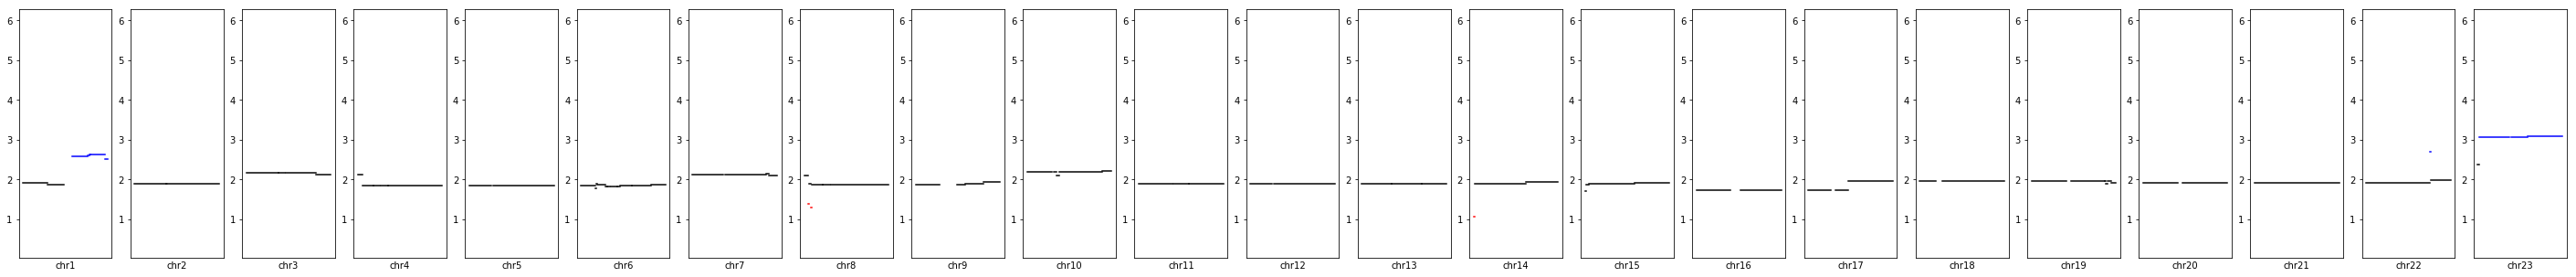

In [38]:
idx = 6000
comm.plotSegments(test_cyto[idx]['segments'])

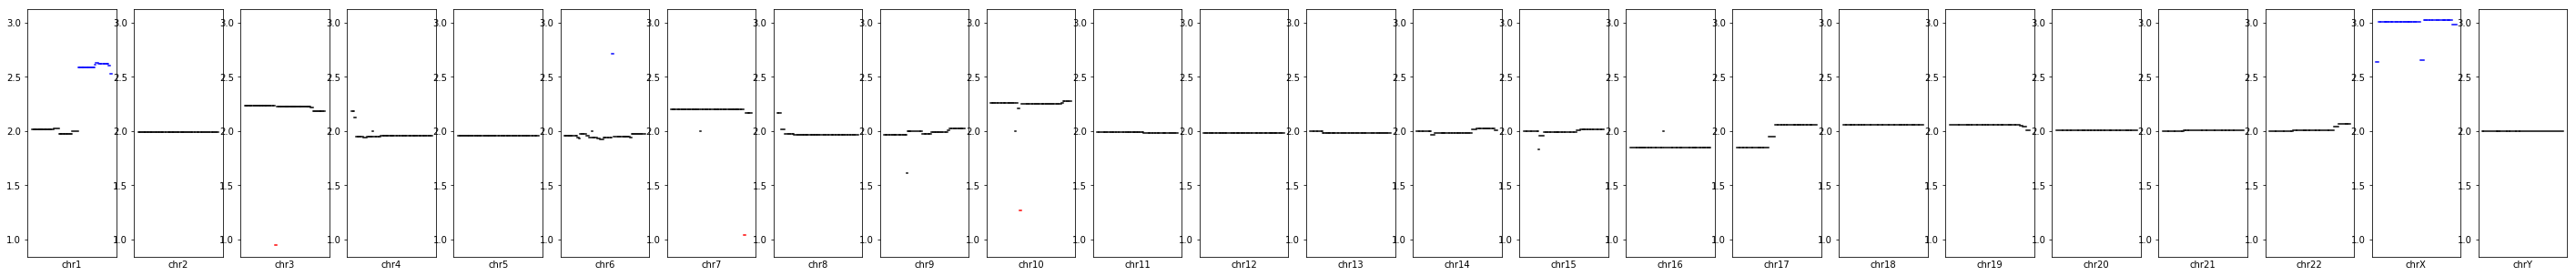

In [39]:
for seg in test_cyto[idx]['cytobands']:
    seg['probes'] = 10
    seg['value'] = seg['ave_del'] + seg['ave_dup']

comm.plotSegments(test_cyto[idx]['cytobands'])

In [28]:
samples[2]['cytobands']

[{'ave_del': 0,
  'ave_dup': 0,
  'chro': '1',
  'del_count': 0,
  'del_length': 0,
  'dup_count': 0,
  'dup_length': 0,
  'end': 2300000,
  'name': 'p36.33',
  'note': 'gneg',
  'probes': 10,
  'start': 0,
  'total_del': 0,
  'total_dup': 0,
  'value': 0},
 {'ave_del': 0,
  'ave_dup': 0.1303,
  'chro': '1',
  'del_count': 0,
  'del_length': 0,
  'dup_count': 1,
  'dup_length': 1998235,
  'end': 5300000,
  'name': 'p36.32',
  'note': 'gpos25',
  'probes': 10,
  'start': 2300000,
  'total_del': 0,
  'total_dup': 260370.02049999998,
  'value': 0.1303},
 {'ave_del': 0,
  'ave_dup': 0.1303,
  'chro': '1',
  'del_count': 0,
  'del_length': 0,
  'dup_count': 1,
  'dup_length': 1800000,
  'end': 7100000,
  'name': 'p36.31',
  'note': 'gneg',
  'probes': 10,
  'start': 5300000,
  'total_del': 0,
  'total_dup': 234540.0,
  'value': 0.1303},
 {'ave_del': 0,
  'ave_dup': 0.1331209385732774,
  'chro': '1',
  'del_count': 0,
  'del_length': 0,
  'dup_count': 2,
  'dup_length': 1999716,
  'end': 910